In [42]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import cv2

In [2]:
print(torch.backends.mps.is_built())

True


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set memory limit
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # Set the desired memory limit (in MB)
    except RuntimeError as e:
        print(e)


In [5]:
torch.set_default_device(0)

## Data loading and exploration

In [6]:
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [7]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [8]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [10]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [11]:
data['Labels'].value_counts()

Labels
Lung Adenocarcinoma             5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: count, dtype: int64

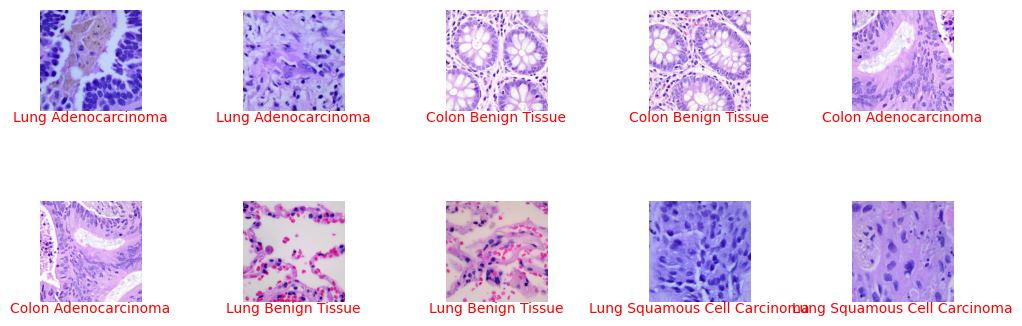

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Preprocessing

In [13]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [14]:
traindf["Labels"].value_counts()

Labels
Colon Benign Tissue             4000
Lung Squamous Cell Carcinoma    4000
Colon Adenocarcinoma            4000
Lung Benign Tissue              4000
Lung Adenocarcinoma             4000
Name: count, dtype: int64

In [15]:
validationdf['Labels'].value_counts()

Labels
Lung Adenocarcinoma             500
Lung Squamous Cell Carcinoma    500
Colon Benign Tissue             500
Colon Adenocarcinoma            500
Lung Benign Tissue              500
Name: count, dtype: int64

In [16]:
testdf['Labels'].value_counts()

Labels
Lung Benign Tissue              500
Colon Adenocarcinoma            500
Lung Squamous Cell Carcinoma    500
Colon Benign Tissue             500
Lung Adenocarcinoma             500
Name: count, dtype: int64

In [17]:
from sklearn.tree import DecisionTreeClassifier


In [18]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set the batch size and image dimensions
image_size = (224, 224)  # Adjust this according to your image size

# Create the ImageDataGenerator objects
datagen = ImageDataGenerator(rescale=1.0 / 255)


In [19]:
train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    validationdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='grayscale',  # Set color_mode to 'grayscale'
# Adjust as needed
    batch_size=10,  # Adjust as needed
    class_mode='categorical',  # Adjust based on your label format
    shuffle=False,
    seed=42
)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [20]:
def get_data_from_generator(generator):
    num_samples = generator.samples

    # Initialize empty arrays to store the features and labels
    X = []
    y = []

    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // generator.batch_size):
        batch_X, batch_y = generator.next()
        X.extend(batch_X)
        y.extend(batch_y)

    # Convert the collected data to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape the image data if needed
    if len(X.shape) > 2:
        X = X.reshape(-1, *X.shape[1:])

    return X.reshape(X.shape[0], -1), y


In [21]:
print("TRAIN:")
trainX,trainY = get_data_from_generator(train_generator)
print(len(trainX),len(trainY))

print("VALIDATION:")
validationX,validationY = get_data_from_generator(validation_generator)
print(len(validationX),len(validationY))

print("TEST:")
testX,testY = get_data_from_generator(test_generator)
print(len(testX),len(testY))


TRAIN:
20000 20000
VALIDATION:
2500 2500
TEST:
2500 2500


## DEPTH 5

In [45]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(max_depth=5,criterion='entropy',min_samples_split=5)
clf1.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5)

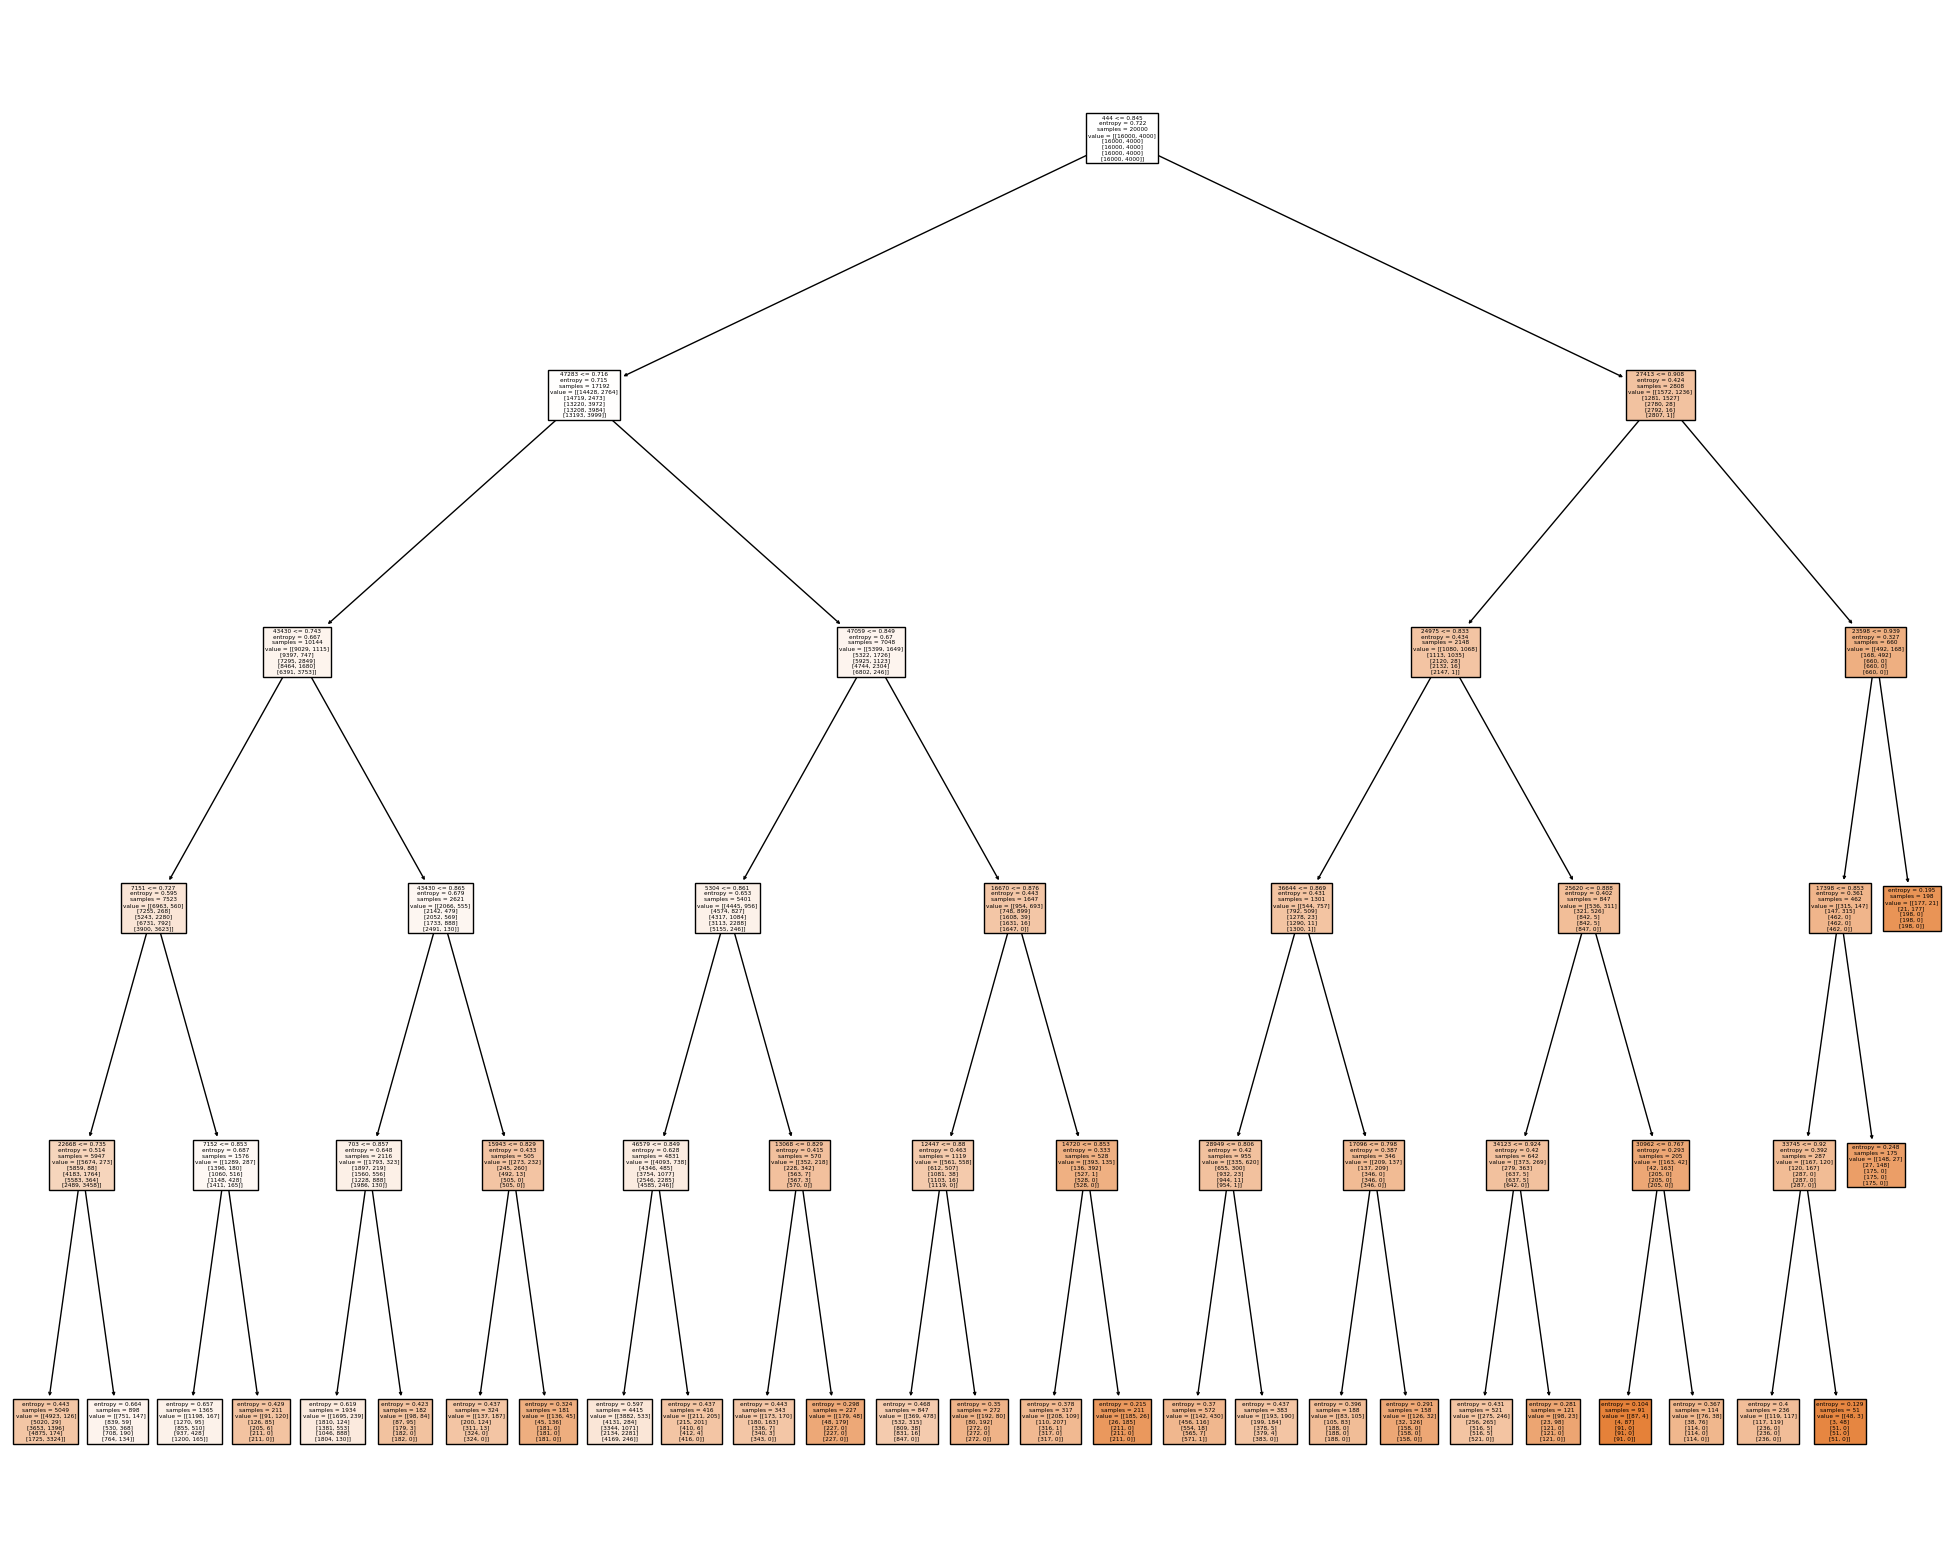

In [23]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
feature_names = [str(i) for i in range(trainX.shape[1])] 
class_names = [str(label) for label in train_generator.classes]  # Convert class labels to strings
_ = tree.plot_tree(clf1,
                   feature_names=feature_names,
                   class_names=class_names,
                   filled=True)

In [46]:
y_val_pred1 = clf1.predict(validationX)
val_accuracy1 = accuracy_score(validationY, y_val_pred1)

# Evaluate the model on the test set
y_test_pred1 = clf1.predict(testX)
test_accuracy1 = accuracy_score(testY, y_test_pred1)

print("Validation Accuracy:", val_accuracy1)
print("Test Accuracy:", test_accuracy1)
print("Train Accuracy:",accuracy_score(trainY,clf1.predict(trainX)))

Validation Accuracy: 0.4124
Test Accuracy: 0.416
Train Accuracy: 0.45315


In [47]:
report = classification_report(testY, y_test_pred,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.28      0.36       500
           1       0.62      0.45      0.52       500
           2       0.00      0.00      0.00       500
           3       0.48      0.56      0.52       500
           4       0.64      0.79      0.71       500

   micro avg       0.57      0.42      0.48      2500
   macro avg       0.45      0.42      0.42      2500
weighted avg       0.45      0.42      0.42      2500
 samples avg       0.42      0.42      0.42      2500



/Users/sneheepatel/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sneheepatel/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DEPTH 10

In [48]:
clf2 = DecisionTreeClassifier(max_depth=10,criterion='entropy',min_samples_split=5)
clf2.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)

In [49]:
y_val_pred2 = clf2.predict(validationX)
val_accuracy2 = accuracy_score(validationY, y_val_pred2)

# Evaluate the model on the test set
y_test_pred2 = clf2.predict(testX)
test_accuracy2 = accuracy_score(testY, y_test_pred2)

print("Validation Accuracy:", val_accuracy2)
print("Test Accuracy:", test_accuracy2)

Validation Accuracy: 0.6112
Test Accuracy: 0.61


In [50]:
report = classification_report(testY, y_test_pred,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.53      0.56       500
           1       0.67      0.59      0.63       500
           2       0.50      0.40      0.45       500
           3       0.69      0.79      0.74       500
           4       0.76      0.73      0.74       500

   micro avg       0.65      0.61      0.63      2500
   macro avg       0.64      0.61      0.62      2500
weighted avg       0.64      0.61      0.62      2500
 samples avg       0.61      0.61      0.61      2500



/Users/sneheepatel/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DEPTH 15

In [51]:
clf3 = DecisionTreeClassifier(max_depth=15,criterion='entropy',min_samples_split=5)
clf3.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=5)

In [52]:
y_val_pred3 = clf3.predict(validationX)
val_accuracy3 = accuracy_score(validationY, y_val_pred3)

# Evaluate the model on the test set
y_test_pred3 = clf3.predict(testX)
test_accuracy3 = accuracy_score(testY, y_test_pred3)

print("Validation Accuracy:", val_accuracy3)
print("Test Accuracy:", test_accuracy3)

Validation Accuracy: 0.6556
Test Accuracy: 0.6468


In [53]:
report = classification_report(testY, y_test_pred,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.56      0.55      0.56       500
           1       0.66      0.61      0.63       500
           2       0.54      0.46      0.50       500
           3       0.74      0.80      0.77       500
           4       0.73      0.82      0.77       500

   micro avg       0.66      0.65      0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500
 samples avg       0.65      0.65      0.65      2500



/Users/sneheepatel/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DEPTH 15 : GINI

In [33]:
clf4 = DecisionTreeClassifier(max_depth=15,criterion='gini',min_samples_split=5)
clf4.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=15, min_samples_split=5)

In [34]:
y_val_pred = clf4.predict(validationX)
val_accuracy = accuracy_score(validationY, y_val_pred)

# Evaluate the model on the test set
y_test_pred = clf4.predict(testX)
test_accuracy = accuracy_score(testY, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.6488
Test Accuracy: 0.636


## DEPTH: UNDEFINED

In [54]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(trainX,trainY)

DecisionTreeClassifier(criterion='entropy')

In [57]:
y_val_pred4 = clf.predict(validationX)
val_accuracy4 = accuracy_score(validationY, y_val_pred4)

# Evaluate the model on the test set
y_test_pred4 = clf.predict(testX)
test_accuracy4 = accuracy_score(testY, y_test_pred4)

print("Validation Accuracy:", val_accuracy4)
print("Test Accuracy:", test_accuracy4)

Validation Accuracy: 0.6684
Test Accuracy: 0.6412


In [58]:
report = classification_report(testY, y_test_pred,zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.55      0.52      0.54       500
           1       0.64      0.60      0.62       500
           2       0.53      0.55      0.54       500
           3       0.73      0.76      0.75       500
           4       0.74      0.76      0.75       500

   micro avg       0.64      0.64      0.64      2500
   macro avg       0.64      0.64      0.64      2500
weighted avg       0.64      0.64      0.64      2500
 samples avg       0.64      0.64      0.64      2500



In [59]:
tree_depth = clf.tree_.max_depth
print("Depth of the decision tree:", tree_depth)

Depth of the decision tree: 34


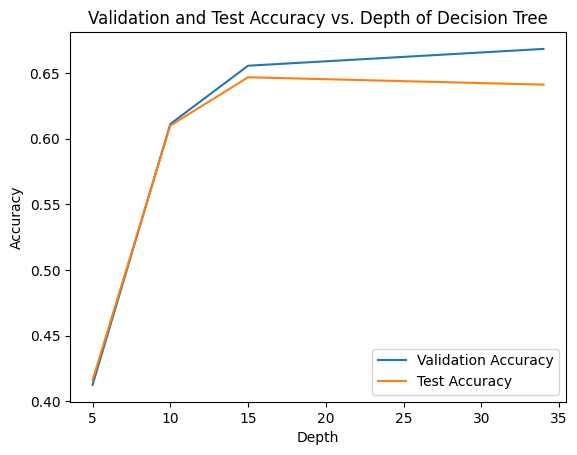

In [60]:
# Plot add
depths = [5,10,15,34]
val_accuracy = [val_accuracy1,val_accuracy2,val_accuracy3,val_accuracy4]
test_accuracy = [test_accuracy1,test_accuracy2,test_accuracy3,test_accuracy4] 

plt.plot(depths, val_accuracy, label='Validation Accuracy')
plt.plot(depths, test_accuracy, label='Test Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy vs. Depth of Decision Tree')
plt.legend()
plt.show()

In [70]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

fig.add_trace(go.Scatter(x=depths, y=val_accuracy, mode='lines', name='Validation Accuracy'))
fig.add_trace(go.Scatter(x=depths, y=test_accuracy, mode='lines', name='Test Accuracy'))

fig.update_layout(
    xaxis_title='Depth',
    yaxis_title='Accuracy',
    title='Validation and Test Accuracy vs. Depth of Decision Tree',
    legend=dict(x=0.7, y=0.9),
    showlegend=True
)

fig.show(renderer='browser')
pio.write_html(fig, file='plot.html', auto_open=True)


# CNN